In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from birfi.birfi import Birfi
from birfi.utils import plot_dataset, partial_convolution, generate_truncated_exponential

# Simulate artificial multi-channel data

## Fix simulation parameters

In [2]:
T = 200                # number of time points
C = 9                 # number of channels
dt = 0.01              # time step
true_k = 0.03           # shared decay rate
noise_level = 0.01     # additive noise
bkg_level = 0.10        # background strength

time = torch.arange(T, dtype=torch.float32) * dt

## Simulate IRFs

In [3]:
torch.manual_seed(0)  # reproducibility

irfs = torch.zeros(T, C)

for c in range(C):
    peak_idx_1 = torch.randint(T//2 - 0, T//2 + 20, (1,)).item()   # random peak location
    sigma = 4
    t = torch.arange(T)
    irf = torch.exp(-0.5 * ((t - peak_idx_1)/sigma)**2)
    peak_idx_2 = peak_idx_1 + torch.randint(-15, 15, (1,)).item()   # random peak location
    irf +=0.7 * torch.exp(-0.5 * ((t - peak_idx_2)/sigma)**2)
    irf /= irf.sum()  # normalize
    irfs[:, c] = irf

## Plot true IRFs

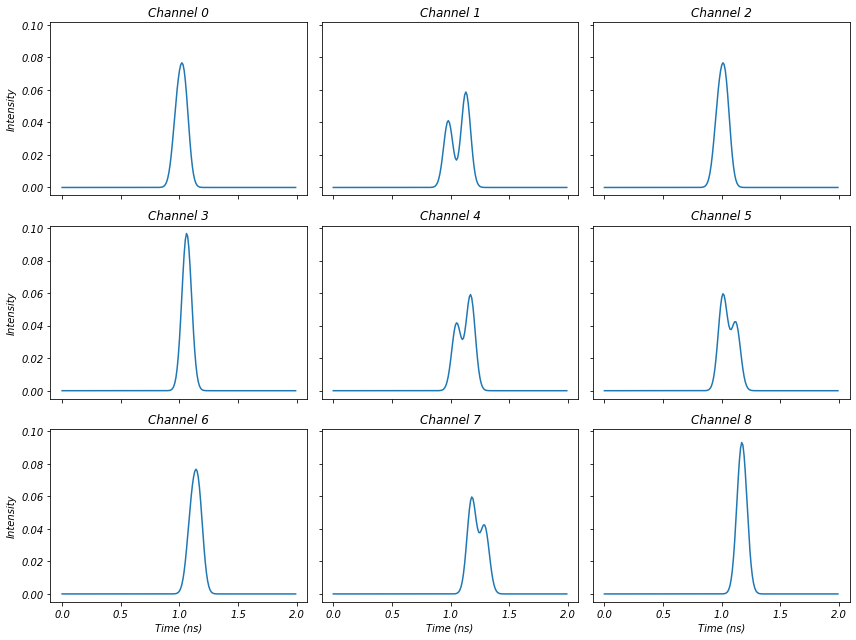

In [4]:
_ = plot_dataset(time.numpy(), irfs)

## Simulate mono-exponential decay

In [5]:
params = {'A' : 1,
          'k' : true_k/dt,
          'C' : bkg_level,
          't0': 0,
    }

exp_decay = generate_truncated_exponential(time, params)

Text(0, 0.5, 'Intensity')

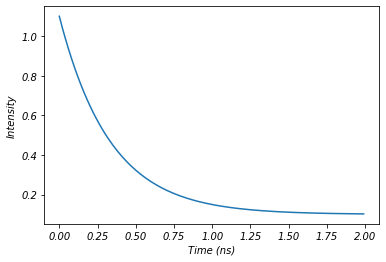

In [6]:
plt.figure()
plt.plot(time, exp_decay)
plt.xlabel('Time (ns)')
plt.ylabel('Intensity')

## Forward model

In [7]:
data = partial_convolution(exp_decay, irfs, dim1 = 'x', dim2 = 'xc', axis = 'x', fourier = (0,0)) # convolve exponential with IRFs
data += bkg_level*torch.rand((1,C,)) # add background
data += noise_level * torch.rand((T,C)) # add noise

## Plot raw dataset

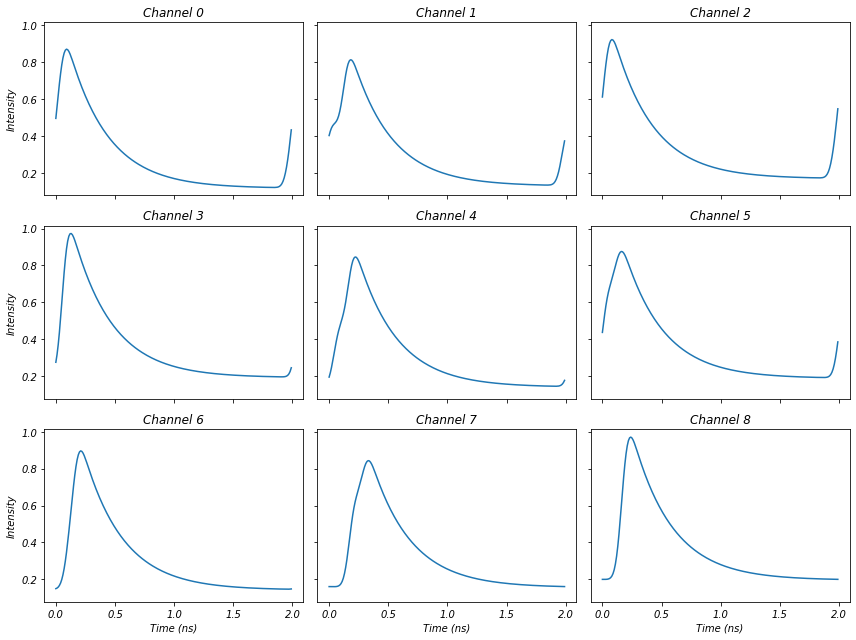

In [8]:
_ = plot_dataset(time, data)

# Run BIRFI

## Initialize Birfi object with the dataset and the sampling step

In [9]:
b = Birfi(data, dt=dt)

## Run the algorithm

In [10]:
retrieved_irf = b.run(lr=5e-2, steps=2000, rl_iterations=100, regularization = 3)

tensor(0.2974)


In [11]:
1/b.params['k']

0.33369198245769804

In [12]:
print(1/params['k'])

0.3333333333333333


## Plot the fit of the multi-channel data, sharing the same lifetime

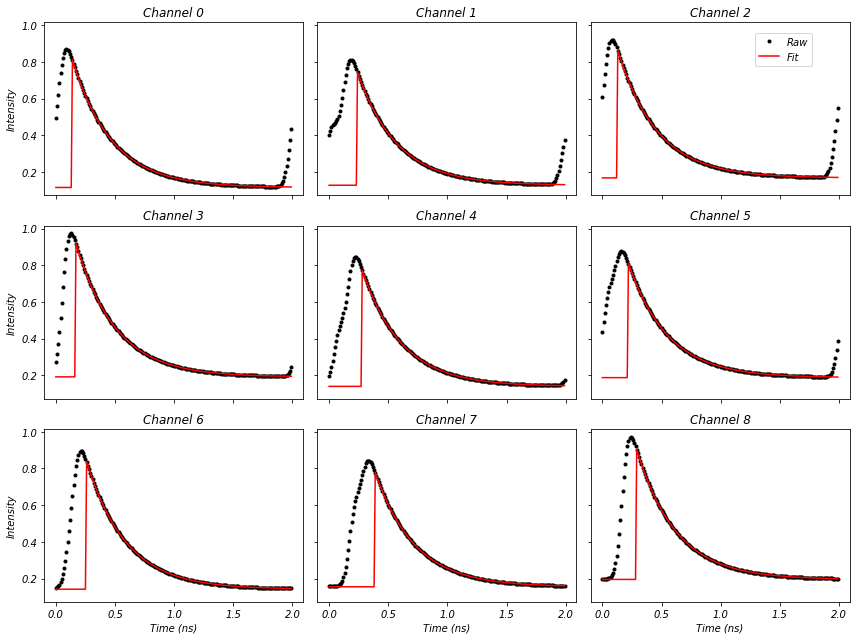

In [13]:
_ = b.plot_raw_and_fit()

## Plot data and the forward model using the retrieved IRFs

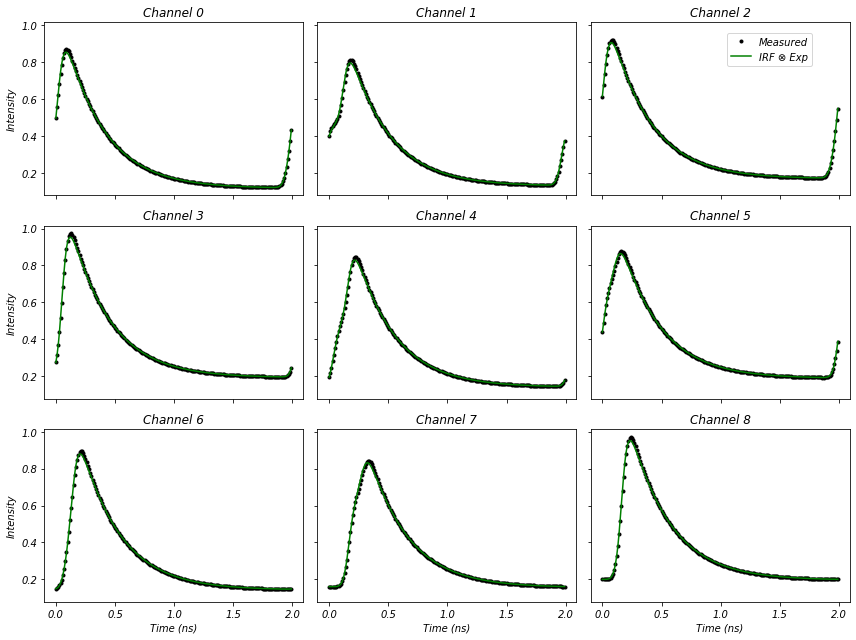

In [14]:
b.plot_forward_model()

## Compare ground-truth and retrieved IRFs

In [15]:
ground_truth = irfs / irfs.max(dim = 0, keepdim=True).values # normalize amplitude
measured_irfs = retrieved_irf / retrieved_irf.max(dim = 0, keepdim=True).values # normalize amplitude

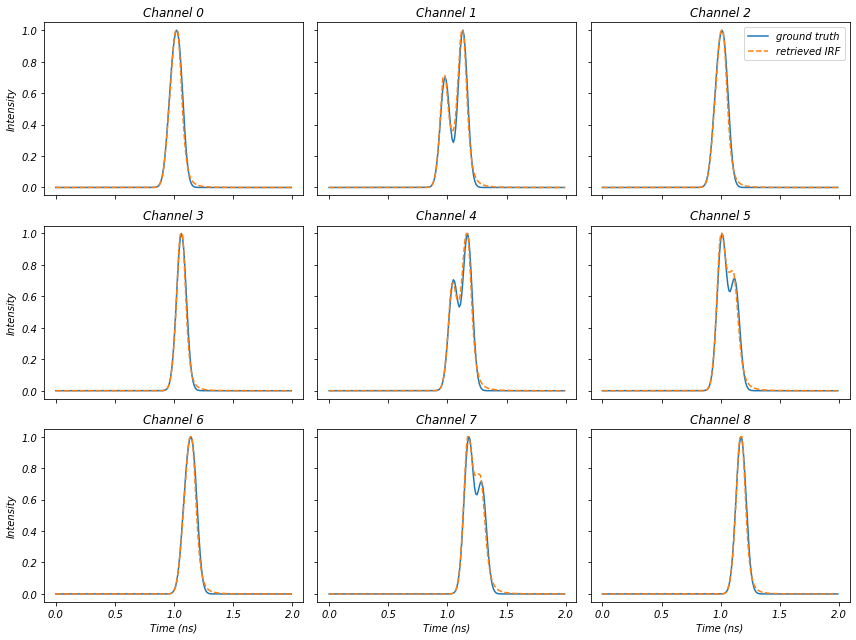

In [16]:
fig, ax = plot_dataset(b.time, ground_truth)

fig, ax = plot_dataset(b.time, measured_irfs, fig = fig, ax = ax, color = 'C1', linestyle='dashed')
ax[2].legend(['ground truth', 'retrieved IRF'])